# Contents

This notebook contains several SQL queries to synthetic and fictitious data. I have organized the notebook into 7 logical sections:

* Mapping Table
* Parsing JSON
* Create and Load Staging Tables
* Validation of Staging Tables
* Data Cleansing
* Preliminary Analytics
* Recommendation

Please refer to the Readme file in the corresponding GitHub repository for context about this project.

# Included Modules and Packages

Code cell containing included modules and packages

In [19]:
import csv
import pandas as pd
import numpy as np
import math
import json
import psycopg2
from fuzzywuzzy import fuzz
from fuzzywuzzy import process as fuzz_process
import matplotlib.pyplot as plt
%matplotlib inline

# Included Modules and Packages

Code cell containing included modules and packages

In [2]:
# Function to run a select query and return rows in a pandas dataframe
# Pandas puts all numeric values from postgres to float
# If it will fit in an integer, change it to integer


def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [3]:
# Connect to Postgres

connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

# Create a cursor for the connection

cursor = connection.cursor()

In [4]:
# Function to read a csv file

def my_read_csv_file(file_name, limit):
    "read the csv file and print only the first limit rows"
    
    csv_file = open(file_name, "r")
    
    csv_data = csv.reader(csv_file)
    
    i = 0
    
    for row in csv_data:
        i += 1
        if i <= limit:
            print(row)
            
    print("\nPrinted ", min(limit, i), "lines of ", i, "total lines.")

In [5]:
# Helper function to print out nested json

def my_recursive_print_json(j, level = -1):
    "given a json object print it"
    
    level += 1
    
    spaces = "    "
    
    if type(j) is dict:
        dict_2_list = list(j.keys())
        for k in dict_2_list:
            print(spaces * level + k)
            my_recursive_print_json(j[k], level)
            
    elif type(j) is list:
        for (i, l) in enumerate(j):
            print(spaces * level + "[" + str(i) + "]")
            my_recursive_print_json(l, level)
                  
    else:
        print(spaces * level + "value:", str(j))

In [6]:
# Function to read nested json

def my_read_nested_json(file_name):
    "given a file of json, read it and parse it meaningfully"
    
    f = open(file_name, "r")
    
    j = json.load(f)
    
    f.close
    
    my_recursive_print_json(j)

# Mapping Table

## Drop, create, and load a product mapping table in PostgreSQL

In [7]:
# Drop the product mapping table if it exists

connection.rollback()

query = """

drop table if exists peak_product_mapping

"""

cursor.execute(query)

connection.commit()

# Create product mapping table

connection.rollback()

query = """

create table peak_product_mapping (
  product_id numeric(3),
  peak_product_id numeric(12),
  PRIMARY KEY (product_id)
);

"""

cursor.execute(query)

connection.commit()

# Create a data frame

data = {"product_id": [1,
                       2, 
                       3, 
                       4, 
                       5, 
                       6, 
                       7, 
                       8],
       "peak_product_id": [42314677,
                          42314678,
                          42314679,
                          42314780,
                          42314781,
                          42314782,
                          42314783,
                          42314784]}

df = pd.DataFrame(data)

In [8]:
# Read the data frame to csv

df.to_csv("peak_product_mapping.csv", index=False)

In [9]:
# Call the function to print the csv

my_read_csv_file("peak_product_mapping.csv", limit = 10)

['product_id', 'peak_product_id']
['1', '42314677']
['2', '42314678']
['3', '42314679']
['4', '42314780']
['5', '42314781']
['6', '42314782']
['7', '42314783']
['8', '42314784']

Printed  9 lines of  9 total lines.


In [10]:
# Load the csv file into the database table

connection.rollback()

query = """

copy peak_product_mapping
from '/user/projects/ucb_mids_w205_project_2/peak_product_mapping.csv' delimiter ',' NULL '' csv header;

"""

cursor.execute(query)

connection.commit()

In [11]:
# Verify that the product mapping table was loaded correcty to the database

rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from peak_product_mapping;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,product_id,peak_product_id
0,1,42314677
1,2,42314678
2,3,42314679
3,4,42314780
4,5,42314781
5,6,42314782
6,7,42314783
7,8,42314784


In [12]:
# Join to the products table and pull the description as product name

rollback_before_flag = True
rollback_after_flag = True

query = """

select p.product_id,
        pmt.peak_product_id,
        p.description as product_name  
from peak_product_mapping as pmt
    join products as p
        on p.product_id = pmt.product_id
group by p.product_id, pmt.peak_product_id, p.description
order by p.product_id
;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,product_id,peak_product_id,product_name
0,1,42314677,Pistachio Salmon
1,2,42314678,Teriyaki Chicken
2,3,42314679,Spinach Orzo
3,4,42314780,Eggplant Lasagna
4,5,42314781,Chicken Salad
5,6,42314782,Curry Chicken
6,7,42314783,Tilapia Piccata
7,8,42314784,Brocolli Stir Fry


# Parsing JSON

## Recursive walk through json file

In [20]:
my_read_nested_json("./data/peak_sales_2020_10_03.json")

creator
    value: Peak Deliveries
timestamp
    value: 2020-10-04 02:00:00
file_name
    value: peak_sales_2020_10_03.json
version
    value: 17.11.7
legal
    value: Unauthorized use, duplication, or possession, blah, blah
sales
    [0]
        sale_id
            value: 5763728874
        sale_date
            value: 2020-10-03
        sub_total
            value: 12
        tax
            value: 0
        total_amount
            value: 12
        pickup_from
            location_id
                value: 12573
            name
                value: Acme Gourmet Meals
            street
                value: 3000 Telegraph Ave
            city
                value: Berkeley
            state
                value: CA
            zip
                value: 94705
        deliver_to
            customer_id
                value: 3728404
            first_name
                value: Darrelle
            last_name
                value: Dohrmann
            street
                va

                    value: N
            [2]
                product_id
                    value: 42314784
                price
                    value: 12
                quantity
                    value: 1
                taxable
                    value: N
    [16]
        sale_id
            value: 5763728832
        sale_date
            value: 2020-10-03
        sub_total
            value: 24
        tax
            value: 0
        total_amount
            value: 24
        pickup_from
            location_id
                value: 12573
            name
                value: Acme Gourmet Meals
            street
                value: 3000 Telegraph Ave
            city
                value: Berkeley
            state
                value: CA
            zip
                value: 94705
        deliver_to
            customer_id
                value: 3729081
            first_name
                value: Armand
            last_name
                value: Olyet
     

            street
                value: 65 South Junction
            city
                value: Oakland
            state
                value: CA
            zip
                value: 94606
        line_items
            [0]
                product_id
                    value: 42314678
                price
                    value: 12
                quantity
                    value: 2
                taxable
                    value: N
            [1]
                product_id
                    value: 42314782
                price
                    value: 12
                quantity
                    value: 1
                taxable
                    value: N
            [2]
                product_id
                    value: 42314784
                price
                    value: 12
                quantity
                    value: 1
                taxable
                    value: N
    [33]
        sale_id
            value: 5763728432
        sale_da

                value: 3000 Telegraph Ave
            city
                value: Berkeley
            state
                value: CA
            zip
                value: 94705
        deliver_to
            customer_id
                value: 3728875
            first_name
                value: D'arcy
            last_name
                value: Lashley
            street
                value: 1371 Esch Lane
            city
                value: Oakland
            state
                value: CA
            zip
                value: 94607
        line_items
            [0]
                product_id
                    value: 42314677
                price
                    value: 12
                quantity
                    value: 1
                taxable
                    value: N
            [1]
                product_id
                    value: 42314678
                price
                    value: 12
                quantity
                    value: 1
    

                    value: 42314782
                price
                    value: 12
                quantity
                    value: 5
                taxable
                    value: N
            [4]
                product_id
                    value: 42314783
                price
                    value: 12
                quantity
                    value: 1
                taxable
                    value: N
    [64]
        sale_id
            value: 5763728624
        sale_date
            value: 2020-10-03
        sub_total
            value: 108
        tax
            value: 0
        total_amount
            value: 108
        pickup_from
            location_id
                value: 12573
            name
                value: Acme Gourmet Meals
            street
                value: 3000 Telegraph Ave
            city
                value: Berkeley
            state
                value: CA
            zip
                value: 94705
        deliver

                quantity
                    value: 1
                taxable
                    value: N
            [1]
                product_id
                    value: 42314784
                price
                    value: 12
                quantity
                    value: 1
                taxable
                    value: N
    [79]
        sale_id
            value: 5763728722
        sale_date
            value: 2020-10-03
        sub_total
            value: 72
        tax
            value: 0
        total_amount
            value: 72
        pickup_from
            location_id
                value: 12573
            name
                value: Acme Gourmet Meals
            street
                value: 3000 Telegraph Ave
            city
                value: Berkeley
            state
                value: CA
            zip
                value: 94705
        deliver_to
            customer_id
                value: 3729149
            first_name
        

                    value: 1
                taxable
                    value: N
            [2]
                product_id
                    value: 42314780
                price
                    value: 12
                quantity
                    value: 1
                taxable
                    value: N
            [3]
                product_id
                    value: 42314782
                price
                    value: 12
                quantity
                    value: 2
                taxable
                    value: N
            [4]
                product_id
                    value: 42314784
                price
                    value: 12
                quantity
                    value: 1
                taxable
                    value: N
    [95]
        sale_id
            value: 5763729237
        sale_date
            value: 2020-10-03
        sub_total
            value: 60
        tax
            value: 0
        total_amount
       

## Parse the json file into csv files

In [21]:
def my_extract_stores_nested_json_to_csv(file_name):
    '''Extract peak sales nested json to csv files'''
    
    f = open(file_name, "r")
    j = json.load(f)
    f.close()   
    
    sales_json_list = []
    stores_json_list = []
    customers_json_list = []
    line_items_json_list = []
    
    for sale in j["sales"]:
        
        sale_json = {}
        sale_json["sale_id"] = sale["sale_id"]
        sale_json["sale_date"] = sale["sale_date"]
        sale_json["sub_total"] = sale["sub_total"]
        sale_json["tax"] = sale["tax"]
        sale_json["total_amount"] = sale["total_amount"]
        line_items = 1
        
        sales_json_list.append(sale_json)
        
        # Add to the stores_json_list
        
        store_json = {}
        store_json["sale_id"] = sale["sale_id"]
        store_json["location_id"] = sale["pickup_from"]["location_id"]
        store_json["name"] = sale["pickup_from"]["name"]
        store_json["street"] = sale["pickup_from"]["street"]
        store_json["city"] = sale["pickup_from"]["city"]
        store_json["state"] = sale["pickup_from"]["state"]
        store_json["zip"] = sale["pickup_from"]["zip"]
        stores_json_list.append(store_json)
    
        # Add to the customers_json_list
        
        customer_json = {}
        customer_json = {}
        customer_json["sale_id"] = sale["sale_id"]
        customer_json["customer_id"] = sale["deliver_to"]["customer_id"]
        customer_json["first_name"] = sale["deliver_to"]["first_name"]
        customer_json["last_name"] = sale["deliver_to"]["last_name"]
        customer_json["street"] = sale["deliver_to"]["street"]
        customer_json["city"] = sale["deliver_to"]["city"]
        customer_json["state"] = sale["deliver_to"]["state"]
        customer_json["zip"] = sale["deliver_to"]["zip"]
        customers_json_list.append(customer_json)
            
        # Add to the line_items_json_list    
        
        for item in sale["line_items"]:
            
            items_json = {}
            items_json["sale_id"] = sale["sale_id"]
            items_json["line_item_id"] = line_items
            line_items += 1
            items_json["product_id"] = item["product_id"]
            items_json["price"] = item["price"]
            items_json["quantity"] = item["quantity"]
            items_json["taxable"] = item["taxable"]
            
            line_items_json_list.append(items_json)
            
    f = open("peak_sales.csv", "w")
    dw = csv.DictWriter(f, sales_json_list[0].keys())
    dw.writeheader()
    dw.writerows(sales_json_list)
    f.close()
    
    f = open("peak_stores.csv", "w")
    dw = csv.DictWriter(f, stores_json_list[0].keys())
    dw.writeheader()
    dw.writerows(stores_json_list)
    f.close()
    
    f = open("peak_customers.csv", "w")
    dw = csv.DictWriter(f, customers_json_list[0].keys())
    dw.writeheader()
    dw.writerows(customers_json_list)
    f.close()
      
    f = open("peak_line_items.csv", "w")
    dw = csv.DictWriter(f, line_items_json_list[0].keys())
    dw.writeheader()
    dw.writerows(line_items_json_list)
    f.close()

In [23]:
my_extract_stores_nested_json_to_csv("./data/peak_sales_2020_10_03.json")

## Validate the output

In [24]:
# Check output

my_read_csv_file("./data/peak_sales.csv", limit=10)

['sale_id', 'sale_date', 'sub_total', 'tax', 'total_amount']
['5763728874', '2020-10-03', '12', '0', '12']
['5763729036', '2020-10-03', '72', '0', '72']
['5763728904', '2020-10-03', '24', '0', '24']
['5763728973', '2020-10-03', '96', '0', '96']
['5763728757', '2020-10-03', '108', '0', '108']
['5763729051', '2020-10-03', '144', '0', '144']
['5763729153', '2020-10-03', '24', '0', '24']
['5763728608', '2020-10-03', '96', '0', '96']
['5763728696', '2020-10-03', '84', '0', '84']

Printed  10 lines of  98 total lines.


In [25]:
# Check output

my_read_csv_file("./data/peak_stores.csv", limit=10)

['sale_id', 'location_id', 'name', 'street', 'city', 'state', 'zip']
['5763728874', '12573', 'Acme Gourmet Meals', '3000 Telegraph Ave', 'Berkeley', 'CA', '94705']
['5763729036', '12573', 'Acme Gourmet Meals', '3000 Telegraph Ave', 'Berkeley', 'CA', '94705']
['5763728904', '12573', 'Acme Gourmet Meals', '3000 Telegraph Ave', 'Berkeley', 'CA', '94705']
['5763728973', '12573', 'Acme Gourmet Meals', '3000 Telegraph Ave', 'Berkeley', 'CA', '94705']
['5763728757', '12573', 'Acme Gourmet Meals', '3000 Telegraph Ave', 'Berkeley', 'CA', '94705']
['5763729051', '12573', 'Acme Gourmet Meals', '3000 Telegraph Ave', 'Berkeley', 'CA', '94705']
['5763729153', '12573', 'Acme Gourmet Meals', '3000 Telegraph Ave', 'Berkeley', 'CA', '94705']
['5763728608', '12573', 'Acme Gourmet Meals', '3000 Telegraph Ave', 'Berkeley', 'CA', '94705']
['5763728696', '12573', 'Acme Gourmet Meals', '3000 Telegraph Ave', 'Berkeley', 'CA', '94705']

Printed  10 lines of  98 total lines.


In [26]:
# Check output

my_read_csv_file("./data/peak_customers.csv", limit=10)

['sale_id', 'customer_id', 'first_name', 'last_name', 'street', 'city', 'state', 'zip']
['5763728874', '3728404', 'Darrelle', 'Dohrmann', '46 Farwell Terrace', 'Oakland', 'CA', '94609']
['5763729036', '3729309', 'Moria', 'Greenwood', '8803 Delaware Crossing', 'Berkeley', 'CA', '94705']
['5763728904', '3728508', 'Josiah', 'Hulett', '6755 Melby Plaza', 'Oakland', 'CA', '94612']
['5763728973', '3728534', 'Gayle', 'MacGarrity', '286 Onsgard Center', 'Berkeley', 'CA', '94703']
['5763728757', '3729188', 'Courtenay', 'Shirrell', '75 West Park', 'Emeryville', 'CA', '94608']
['5763729051', '3729276', 'Christian', 'Anyene', '869 Transport Crossing', 'Berkeley', 'CA', '94707']
['5763729153', '3729242', 'Linnell', 'Barr', '521 Fallview Alley', 'Oakland', 'CA', '94602']
['5763728608', '3728705', 'Benedick', 'Staneland', '3852 Laurel Park', 'Berkeley', 'CA', '94704']
['5763728696', '3729340', 'Lanni', 'Pickavant', '481 Moose Pass', 'Oakland', 'CA', '94609']

Printed  10 lines of  98 total lines.


In [27]:
# Check output

my_read_csv_file("./data/peak_line_items.csv", limit=10)

['sale_id', 'line_item_id', 'product_id', 'price', 'quantity', 'taxable']
['5763728874', '1', '42314780', '12', '1', 'N']
['5763729036', '1', '42314677', '12', '1', 'N']
['5763729036', '2', '42314782', '12', '3', 'N']
['5763729036', '3', '42314784', '12', '2', 'N']
['5763728904', '1', '42314780', '12', '1', 'N']
['5763728904', '2', '42314784', '12', '1', 'N']
['5763728973', '1', '42314677', '12', '2', 'N']
['5763728973', '2', '42314780', '12', '2', 'N']
['5763728973', '3', '42314782', '12', '2', 'N']

Printed  10 lines of  353 total lines.


# Create and Load Staging Tables

In [30]:
# Drop tables if they exist

connection.rollback()

query = """

drop table if exists stage_1_peak_sales;
drop table if exists stage_1_peak_stores;
drop table if exists stage_1_peak_customers;
drop table if exists stage_1_peak_line_items;

"""

cursor.execute(query)

connection.commit()

In [31]:
# Create stage_1_peak_sales table with all varchar(100)

connection.rollback()

query = """


create table stage_1_peak_sales (
  stage_id serial,
  sale_id varchar(100),
  sale_date varchar(100),
  sub_total varchar(100),
  tax varchar(100),
  total_amount varchar(100)
);


"""

cursor.execute(query)

connection.commit()

In [32]:
# Create stage_1_peak_stores table with all varchar(100)

connection.rollback()

query = """


create table stage_1_peak_stores (
  stage_id serial,
  sale_id varchar(100),
  location_id varchar(100),
  name varchar(100),
  street varchar(100),
  city varchar(100),
  state varchar(100),
  zip varchar(100)
);


"""

cursor.execute(query)

connection.commit()

In [33]:
# Create stage_1_peak_customers table with all varchar(100)

connection.rollback()

query = """


create table stage_1_peak_customers (
  stage_id serial,
  sale_id varchar(100),
  customer_id varchar(100),
  first_name varchar(100),
  last_name varchar(100),
  street varchar(100),
  city varchar(100),
  state varchar(100),
  zip varchar(100)
);


"""

cursor.execute(query)

connection.commit()

In [34]:
# Create stage_1_peak_line_items table with all varchar(100)

connection.rollback()

query = """


create table stage_1_peak_line_items (
  stage_id serial,
  sale_id varchar(100),
  line_item_id varchar(100),
  product_id varchar(100),
  price varchar(100),
  quantity varchar(100),
  taxable varchar(100)
);


"""

cursor.execute(query)

connection.commit()

In [35]:
# Load csv files into PostgreSQL

connection.rollback()

query = """

copy stage_1_peak_sales (sale_id, sale_date, sub_total, tax, total_amount)
from '/user/projects/ucb_mids_w205_project_2/peak_sales.csv' delimiter ',' NULL '' csv header;
copy stage_1_peak_stores (sale_id, location_id, name, street, city, state, zip)
from '/user/projects/ucb_mids_w205_project_2/peak_stores.csv' delimiter ',' NULL '' csv header;
copy stage_1_peak_customers (sale_id, customer_id, first_name, last_name, street, city, state, zip)
from '/user/projects/ucb_mids_w205_project_2/peak_customers.csv' delimiter ',' NULL '' csv header;
copy stage_1_peak_line_items (sale_id, line_item_id, product_id, price, quantity, taxable)
from '/user/projects/ucb_mids_w205_project_2/peak_line_items.csv' delimiter ',' NULL '' csv header;

"""

cursor.execute(query)

connection.commit()

In [36]:
# Verify the load of stage_1_peak_sales

rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from stage_1_peak_sales
order by stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,stage_id,sale_id,sale_date,sub_total,tax,total_amount
0,1,5763728874,2020-10-03,12,0,12
1,2,5763729036,2020-10-03,72,0,72
2,3,5763728904,2020-10-03,24,0,24
3,4,5763728973,2020-10-03,96,0,96
4,5,5763728757,2020-10-03,108,0,108
...,...,...,...,...,...,...
92,93,5763728927,2020-10-03,72,0,72
93,94,5763729096,2020-10-03,48,0,48
94,95,5763729268,2020-10-03,84,0,84
95,96,5763729237,2020-10-03,60,0,60


In [37]:
# Verify the load of stage_1_peak_stores

rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from stage_1_peak_stores
order by stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,stage_id,sale_id,location_id,name,street,city,state,zip
0,1,5763728874,12573,Acme Gourmet Meals,3000 Telegraph Ave,Berkeley,CA,94705
1,2,5763729036,12573,Acme Gourmet Meals,3000 Telegraph Ave,Berkeley,CA,94705
2,3,5763728904,12573,Acme Gourmet Meals,3000 Telegraph Ave,Berkeley,CA,94705
3,4,5763728973,12573,Acme Gourmet Meals,3000 Telegraph Ave,Berkeley,CA,94705
4,5,5763728757,12573,Acme Gourmet Meals,3000 Telegraph Ave,Berkeley,CA,94705
...,...,...,...,...,...,...,...,...
92,93,5763728927,12573,Acme Gourmet Meals,3000 Telegraph Ave,Berkeley,CA,94705
93,94,5763729096,12573,Acme Gourmet Meals,3000 Telegraph Ave,Berkeley,CA,94705
94,95,5763729268,12573,Acme Gourmet Meals,3000 Telegraph Ave,Berkeley,CA,94705
95,96,5763729237,12573,Acme Gourmet Meals,3000 Telegraph Ave,Berkeley,CA,94705


In [38]:
# Verify the load of stage_1_peak_customers

rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from stage_1_peak_customers
order by stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,stage_id,sale_id,customer_id,first_name,last_name,street,city,state,zip
0,1,5763728874,3728404,Darrelle,Dohrmann,46 Farwell Terrace,Oakland,CA,94609
1,2,5763729036,3729309,Moria,Greenwood,8803 Delaware Crossing,Berkeley,CA,94705
2,3,5763728904,3728508,Josiah,Hulett,6755 Melby Plaza,Oakland,CA,94612
3,4,5763728973,3728534,Gayle,MacGarrity,286 Onsgard Center,Berkeley,CA,94703
4,5,5763728757,3729188,Courtenay,Shirrell,75 West Park,Emeryville,CA,94608
...,...,...,...,...,...,...,...,...,...
92,93,5763728927,3728568,Valina,Spring,119 Sachtjen Junction,Berkeley,CA,94702
93,94,5763729096,3728990,Claire,Mebes,358 Oxford Road,Albany,CA,94706
94,95,5763729268,3728901,Freddy,Mumford,6 Transport Lane,Orinda,CA,94563
95,96,5763729237,3729019,Arv,Doret,2120 Mesta Circle,Emeryville,CA,94608


In [39]:
# Verify the load of stage_1_peak_line_items

rollback_before_flag = True
rollback_after_flag = True

query = """

select * 
from stage_1_peak_line_items
order by stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,stage_id,sale_id,line_item_id,product_id,price,quantity,taxable
0,1,5763728874,1,42314780,12,1,N
1,2,5763729036,1,42314677,12,1,N
2,3,5763729036,2,42314782,12,3,N
3,4,5763729036,3,42314784,12,2,N
4,5,5763728904,1,42314780,12,1,N
...,...,...,...,...,...,...,...
347,348,5763729237,2,42314678,12,2,N
348,349,5763729237,3,42314782,12,2,N
349,350,5763728673,1,42314677,12,2,N
350,351,5763728673,2,42314678,12,1,N


# Validate Data in Staging Tables

In [40]:
# Validate data types in stage_1_peak_sales

rollback_before_flag = True
rollback_after_flag = True

query = """

select sale_id::numeric,
        sale_date::date,
        sub_total::numeric,
        tax::numeric,
        total_amount::numeric
from stage_1_peak_sales
order by stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,sale_id,sale_date,sub_total,tax,total_amount
0,5763728874,2020-10-03,12,0,12
1,5763729036,2020-10-03,72,0,72
2,5763728904,2020-10-03,24,0,24
3,5763728973,2020-10-03,96,0,96
4,5763728757,2020-10-03,108,0,108
...,...,...,...,...,...
92,5763728927,2020-10-03,72,0,72
93,5763729096,2020-10-03,48,0,48
94,5763729268,2020-10-03,84,0,84
95,5763729237,2020-10-03,60,0,60


In [41]:
# Validate data types in stage_1_peak_stores

rollback_before_flag = True
rollback_after_flag = True

query = """

select sale_id::numeric,
        location_id::numeric
from stage_1_peak_stores
order by stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,sale_id,location_id
0,5763728874,12573
1,5763729036,12573
2,5763728904,12573
3,5763728973,12573
4,5763728757,12573
...,...,...
92,5763728927,12573
93,5763729096,12573
94,5763729268,12573
95,5763729237,12573


In [42]:
# Validate data types in stage_1_peak_customers

rollback_before_flag = True
rollback_after_flag = True

query = """

select sale_id::numeric,
        customer_id::numeric
from stage_1_peak_customers
order by stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,sale_id,customer_id
0,5763728874,3728404
1,5763729036,3729309
2,5763728904,3728508
3,5763728973,3728534
4,5763728757,3729188
...,...,...
92,5763728927,3728568
93,5763729096,3728990
94,5763729268,3728901
95,5763729237,3729019


In [43]:
# Validate data types in stage_1_peak_line_items

rollback_before_flag = True
rollback_after_flag = True

query = """

select sale_id::numeric,
        line_item_id::numeric,
        product_id::numeric,
        price::numeric,
        quantity::numeric
from stage_1_peak_line_items
order by stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,sale_id,line_item_id,product_id,price,quantity
0,5763728874,1,42314780,12,1
1,5763729036,1,42314677,12,1
2,5763729036,2,42314782,12,3
3,5763729036,3,42314784,12,2
4,5763728904,1,42314780,12,1
...,...,...,...,...,...
347,5763729237,2,42314678,12,2
348,5763729237,3,42314782,12,2
349,5763728673,1,42314677,12,2
350,5763728673,2,42314678,12,1


In [44]:
# Validate that total_amount = sub_total + tax in stage_1_peak_sales

rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from stage_1_peak_sales
where total_amount::numeric <> (sub_total::numeric + tax::numeric)
order by stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,stage_id,sale_id,sale_date,sub_total,tax,total_amount


In [45]:
# Validate that total_amount = price * sum(quantity) in stage_1_peak_sales and stage_1_peak_line_items

rollback_before_flag = True
rollback_after_flag = True

query = """

select sa.stage_id as peak_sales_stage_id,
        sa.sale_id as peak_sales_sale_id
from stage_1_peak_sales as sa
    join stage_1_peak_line_items as l
        on sa.sale_id = l.sale_id
group by sa.stage_id, sa.sale_id, sa.total_amount, l.price
having sa.total_amount::numeric <> l.price::numeric * sum(l.quantity::numeric)
order by sa.stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,peak_sales_stage_id,peak_sales_sale_id


In [46]:
# Validate that tax = 0 in stage_1_peak_sales

rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from stage_1_peak_sales
where tax::numeric <> 0
order by stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,stage_id,sale_id,sale_date,sub_total,tax,total_amount


In [47]:
# Validate that price = 12 in stage_1_peak_line_items

rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from stage_1_peak_line_items
where price::numeric <> 12
order by stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,stage_id,sale_id,line_item_id,product_id,price,quantity,taxable


In [48]:
# Validate that taxable = N in stage_1_peak_line_items

rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from stage_1_peak_line_items
where taxable::text <> 'N'
order by stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,stage_id,sale_id,line_item_id,product_id,price,quantity,taxable


In [49]:
# Validate that store is same for all in stage_1_peak_stores

rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from stage_1_peak_stores
where location_id::numeric <> 12573
order by stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,stage_id,sale_id,location_id,name,street,city,state,zip


In [50]:
# Validate product_id in stage_1_peak_line_items against peak_product_mapping

rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from stage_1_peak_line_items
where product_id::numeric not in (
    select peak_product_id
    from peak_product_mapping)
order by stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,stage_id,sale_id,line_item_id,product_id,price,quantity,taxable


# Data Cleansing

In [51]:
# Validate city, state, and zip in stage_1_peak_customers

rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from stage_1_peak_customers
where (city, state, zip) not in (
    select city, state, zip
    from zip_codes)
order by stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,stage_id,sale_id,customer_id,first_name,last_name,street,city,state,zip


In [52]:
# Find first names, last names, and streets that don't match

rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from stage_1_peak_customers
where (first_name, last_name, street) not in (
    select first_name, last_name, street
    from customers)
order by stage_id;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,stage_id,sale_id,customer_id,first_name,last_name,street,city,state,zip
0,10,5763728768,3729016,Hyrum,Knuckles,86668 Spenser Terrace,Oakland,CA,94618
1,20,5763728877,3728936,Roseann,Coyish,11707 American Ash Ter,Orinda,CA,94563
2,24,5763728428,3729287,Hali,Ducker,8 Orion Pass,El Cerrito,CA,94530
3,26,5763728393,3728674,Melantha,Golborn,6140 North Field Alley,Orinda,CA,94563
4,36,5763729212,3729191,Eleni,Jansen,66 Bartelt Hill,Oakland,CA,94607
5,40,5763729129,3728856,Clyve,Humonds,22 Brent Wood Hill,Berkeley,CA,94709
6,51,5763728864,3729178,Rutledge,Hellwing,606 Gulf Plz,El Cerrito,CA,94530
7,60,5763729313,3728402,Kalli,Kemel,18373 Golf View Pass,Berkeley,CA,94702
8,72,5763728980,3729213,Honina,Philson,28 Clarendon Plaza,Berkeley,CA,94702
9,73,5763728921,3729194,Nicky,Haley,88424 Warrior Lane,Oakland,CA,94602


In [53]:
# Find the percentage of customer records from peak that do not match AGM

rollback_before_flag = True
rollback_after_flag = True

query = """

with a as (select count(*) as total_customers 
from stage_1_peak_customers),
b as (select count(*) as total_unmatched
from stage_1_peak_customers
where (first_name, last_name, street) not in (
    select first_name, last_name, street
    from customers))
select a.total_customers, (a.total_customers - b.total_unmatched) as total_matched, b.total_unmatched,
round((b.total_unmatched / a.total_customers::numeric * 100), 1) as pct_unmatched
from a,b;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,total_customers,total_matched,total_unmatched,pct_unmatched
0,97,84,13,13.4


## Executive Summary of Data Quality

It is my understanding that AGM does not want to give its customer data to Peak Deliveries during the proof of concept phase. Instead, customers will sign up independently with Peak through Peak's website, app, or telephone help line in order to have AGM meals delivered. I recommend we continue this practice and withhold our customer data from Peak.

We anticipated prior to the PoC that there would not be a perfect match of customer first names, last names, and addresses between our records and those maintained by Peak. While not all of Peak's customer records match perfectly with our own, the mismatch is relatively small and manageable. More specifically, roughly 13% of the customer records have at least one mismatch. Additionally, the mistakes appear to be correctable. We used fuzzy logic to validate that the Peak names and addresses we were provided are "close enough" to our own that we could use available algorithms to correct them (see below).

Since there are relatively few mismatches and they are fixable, I see no reason to provide our customer data to Peak. Providing this data could be a risk for AGM if Peak were to use it to recommend alternative, nearby meals or restaurants to our customers, which would undoubtedly negatively impact our revenue potential. The most significant drawback of not providing this data to Peak is an impact on our customer experience. Without us providing Peak with their data, they need to manually provide it themselves to Peak. We have no data to suggest, however, that this manual process would cause a customer not to sign up for AGM delivery via Peak.

### Query to pull back mismatched data

In [54]:
# Find first names, last names, and streets that don't match

rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from stage_1_peak_customers
where (first_name, last_name, street) not in (
    select first_name, last_name, street
    from customers)
order by stage_id;

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

# Concatenate first and last names and drop old columns
df["full_name"] = df["first_name"] + " " + df["last_name"]
df.drop(["first_name", "last_name"], axis=1, inplace=True)
df

,stage_id,sale_id,customer_id,street,city,state,zip,full_name
0,10,5763728768,3729016,86668 Spenser Terrace,Oakland,CA,94618,Hyrum Knuckles
1,20,5763728877,3728936,11707 American Ash Ter,Orinda,CA,94563,Roseann Coyish
2,24,5763728428,3729287,8 Orion Pass,El Cerrito,CA,94530,Hali Ducker
3,26,5763728393,3728674,6140 North Field Alley,Orinda,CA,94563,Melantha Golborn
4,36,5763729212,3729191,66 Bartelt Hill,Oakland,CA,94607,Eleni Jansen
5,40,5763729129,3728856,22 Brent Wood Hill,Berkeley,CA,94709,Clyve Humonds
6,51,5763728864,3729178,606 Gulf Plz,El Cerrito,CA,94530,Rutledge Hellwing
7,60,5763729313,3728402,18373 Golf View Pass,Berkeley,CA,94702,Kalli Kemel
8,72,5763728980,3729213,28 Clarendon Plaza,Berkeley,CA,94702,Honina Philson
9,73,5763728921,3729194,88424 Warrior Lane,Oakland,CA,94602,Nicky Haley


### Query to pull back customer data

In [55]:
# Make a list of all customers and addresses maintained by AGM

rollback_before_flag = True
rollback_after_flag = True

query = """

select first_name,
        last_name,
        street
from customers;

"""

cust_df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

# Make 2 lists - one for our customers' names and another for their addresses

cust_df["full_name"] = cust_df["first_name"] + " " + cust_df["last_name"]
agm_cust_list = cust_df["full_name"].tolist()
agm_street_list = cust_df["street"].tolist()

# Use fuzzy logic to provide suggested name and street

df["suggested_name"] = [fuzz_process.extract(name, agm_cust_list, limit = 1)[0][0] for name in df["full_name"]]
df["suggested_street"] = [fuzz_process.extract(street, agm_street_list, limit = 1)[0][0] for street in df["street"]]
df

,stage_id,sale_id,customer_id,street,city,state,zip,full_name,suggested_name,suggested_street
0,10,5763728768,3729016,86668 Spenser Terrace,Oakland,CA,94618,Hyrum Knuckles,Hiram Knuckles,86668 Spenser Terrace
1,20,5763728877,3728936,11707 American Ash Ter,Orinda,CA,94563,Roseann Coyish,Roseann Coyish,11707 American Ash Terrace
2,24,5763728428,3729287,8 Orion Pass,El Cerrito,CA,94530,Hali Ducker,Halli Ducker,8 Orin Pass
3,26,5763728393,3728674,6140 North Field Alley,Orinda,CA,94563,Melantha Golborn,Melantha Golborn,6140 Northfield Alley
4,36,5763729212,3729191,66 Bartelt Hill,Oakland,CA,94607,Eleni Jansen,Eleni Jansen,6 Bartelt Hill
5,40,5763729129,3728856,22 Brent Wood Hill,Berkeley,CA,94709,Clyve Humonds,Clyve Hammonds,22 Brentwood Hill
6,51,5763728864,3729178,606 Gulf Plz,El Cerrito,CA,94530,Rutledge Hellwing,Rutledge Hellwing,606 Prairieview Avenue
7,60,5763729313,3728402,18373 Golf View Pass,Berkeley,CA,94702,Kalli Kemel,Kalli Kemell,18373 Golf View Pass
8,72,5763728980,3729213,28 Clarendon Plaza,Berkeley,CA,94702,Honina Philson,Junina Philson,28 Clarendon Plaza
9,73,5763728921,3729194,88424 Warrior Lane,Oakland,CA,94602,Nicky Haley,Nickey Haley,88424 Warrior Lane


# Preliminary Analytics

In [56]:
# Find the total dollar amount of sales

rollback_before_flag = True
rollback_after_flag = True

query = """

select sum(total_amount::numeric) as total_dollar_sales
from stage_1_peak_sales;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,total_dollar_sales
0,6480


In [57]:
# Find the total number of sales

rollback_before_flag = True
rollback_after_flag = True

query = """

select count(*) as total_number_sales
from stage_1_peak_sales;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,total_number_sales
0,97


In [58]:
# Find the total dollar amount of sales, cut paid to Peak, net to AGM

rollback_before_flag = True
rollback_after_flag = True

query = """

select sum(total_amount::numeric) as total_dollar_sales,
        (sum(total_amount::numeric) * 0.18) as cut_to_peak,
        (sum(total_amount::numeric) - (sum(total_amount::numeric) * 0.18)) as net_AGM
from stage_1_peak_sales;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,total_dollar_sales,cut_to_peak,net_agm
0,6480,1166.4,5313.6


In [59]:
# Find the total number of meals sold

rollback_before_flag = True
rollback_after_flag = True

query = """

select sum(quantity::numeric) as total_num_meals
from stage_1_peak_line_items;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,total_num_meals
0,540


In [60]:
# Find the total number of meals sold, by meal

rollback_before_flag = True
rollback_after_flag = True

query = """

select p.description as meal_name,
        sum(l.quantity::numeric) as total_num_sold
from stage_1_peak_line_items as l
    join peak_product_mapping as pmt
        on l.product_id::numeric = pmt.peak_product_id::numeric
    join products as p
        on pmt.product_id::numeric = p.product_id::numeric
group by p.product_id
order by total_num_sold desc;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,meal_name,total_num_sold
0,Pistachio Salmon,113
1,Eggplant Lasagna,107
2,Curry Chicken,101
3,Teriyaki Chicken,80
4,Brocolli Stir Fry,60
5,Tilapia Piccata,44
6,Spinach Orzo,27
7,Chicken Salad,8


In [61]:
# Find the average number of meals per sale

rollback_before_flag = True
rollback_after_flag = True

query = """

with a as (select sum(quantity::numeric) as total_num_meals
from stage_1_peak_line_items),
b as (select count(*) as total_number_sales
from stage_1_peak_sales)
select round((a.total_num_meals / b.total_number_sales), 2) as avg_meals_per_sale
from a,b;

"""

my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

,avg_meals_per_sale
0,5.57


# Recommendation

## Motivation for the Following Analysis

From our last analysis (query_functional_programming repository), I showed that most customers lived within 15 miles of the closest store and proposed a delivery option to capture market share from customers who lived farther away. The below plot was presented with that analysis and is included again for convenience.

I aim to evaluate if solidifying a delivery option with Peak is a good business decision.

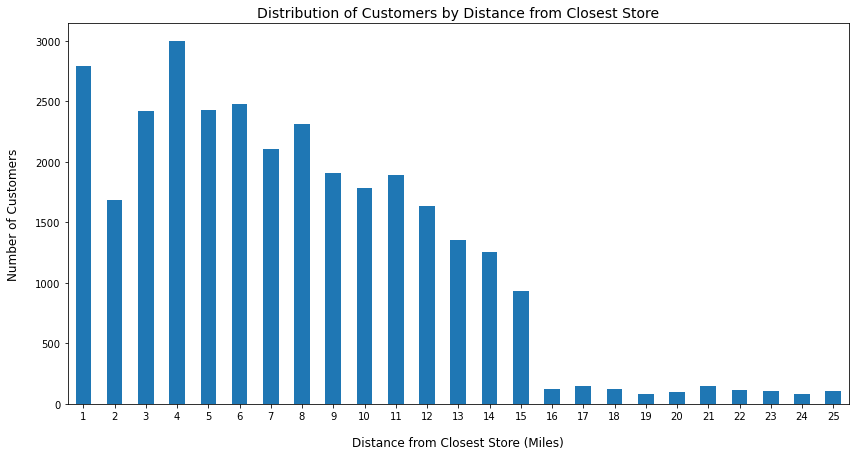

In [64]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select s.city as store,
        cu.distance as distance,
        cu.first_name,
        cu.last_name,
        count(cu.customer_id) as total_customers
from stores as s
    join customers as cu
        on s.store_id = cu.closest_store_id
group by store, distance, cu.first_name, cu.last_name
order by distance

"""

agm_df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

# Plot the results of the above query
fig, ax = plt.subplots()
agm_df.groupby("distance")["total_customers"].sum().plot(kind="bar", figsize=(14,7))

# Add titles and axes labels
plt.title("Distribution of Customers by Distance from Closest Store", fontsize=14)
ax.set_ylabel("Number of Customers", labelpad=15, fontsize=12)
ax.set_xlabel("Distance from Closest Store (Miles)", labelpad=15, fontsize=12)
plt.xticks(rotation=0);

### Visualize Distribution of Customer Addresses in the Berkeley Area

I confirm that the distribution of customer addresses near the Berkeley store is similar to the distribution of customer addresses across all stores. Consistent with the results presented above, most customers in the Berkeley area live within 15 miles of the Berkeley store. 

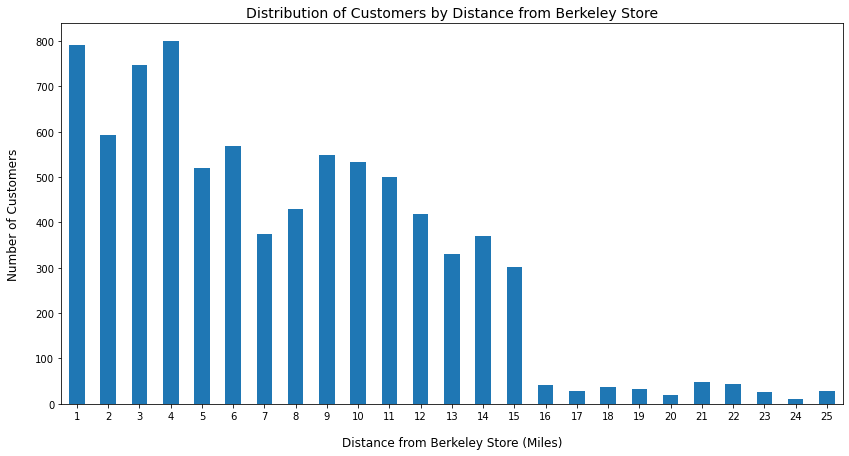

In [65]:
berk_df = agm_df[agm_df["store"] == "Berkeley"]

# Plot the results
fig, ax = plt.subplots()
berk_df.groupby("distance")["total_customers"].sum().plot(kind="bar", figsize=(14,7))

# Add titles and axes labels
plt.title("Distribution of Customers by Distance from Berkeley Store", fontsize=14)
ax.set_ylabel("Number of Customers", labelpad=15, fontsize=12)
ax.set_xlabel("Distance from Berkeley Store (Miles)", labelpad=15, fontsize=12)
plt.xticks(rotation=0);

### Investigate Who Signed Up with Peak

I investigate if the customers who live over 15 miles from the Berkeley store actually signed up for delivery with Peak. I use the fuzzy logic method to correct small inaccuracies in the customer data that Peak maintains. 

##### Build a data frame with the customers who match Peak data

In [66]:
# Find first names, last names, and streets that match

rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from stage_1_peak_customers
where (first_name, last_name, street) in (
    select first_name, last_name, street
    from customers)
order by stage_id;

"""

df_1 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

##### Build a data frame with the customers who don't match Peak data

In [67]:
# Find first names, last names, and streets that don't match

rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from stage_1_peak_customers
where (first_name, last_name, street) not in (
    select first_name, last_name, street
    from customers)
order by stage_id;

"""

df_2 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

# Concatenate first and last names and drop old columns

df_2["full_name"] = df_2["first_name"] + " " + df_2["last_name"]
df_2.drop(["first_name", "last_name"], axis=1, inplace=True)

##### Apply fuzzy logic

In [68]:
# Make a list of all customers and addresses maintained by AGM

rollback_before_flag = True
rollback_after_flag = True

query = """

select first_name,
        last_name,
        street
from customers;

"""

cust_df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

# Make 2 lists - one for our customers' names and another for their addresses

cust_df["full_name"] = cust_df["first_name"] + " " + cust_df["last_name"]
agm_cust_list = cust_df["full_name"].tolist()
agm_street_list = cust_df["street"].tolist()

In [69]:
# Use fuzzy logic to provide suggested name and street

df_2["suggested_name"] = [fuzz_process.extract(name, agm_cust_list, limit = 1)[0][0] for name in df_2["full_name"]]
df_2["suggested_street"] = [fuzz_process.extract(street, agm_street_list, limit = 1)[0][0] for street in df_2["street"]]

In [70]:
# Split the new suggested_name into first and last

df_2[["first_name", "last_name"]] = df_2["suggested_name"].str.split(" ", 1, expand=True)

# Drop unnecessary columns

df_2.drop(["street", "full_name", "suggested_name"], axis=1, inplace=True)

# Rename suggested_street

df_2.rename(columns={"suggested_street": "street"}, inplace=True)

##### Combine the two data frames into a single data frame (this represents the customers who signed up with Peak)


In [71]:
# Generate the data frame to be used for analysis (customers who signed up with Peak)

df = df_1.append(df_2)
df["full_name"] = df["first_name"] + " " + df["last_name"]

### Determine How Close to the Berkeley Store the Peak Customers Live

We find that all customers who signed up for the Peak delivery service live within 5 miles of the Berkeley store.

In [72]:
# Build a column to be used for Boolean filtering

agm_df = agm_df[agm_df["store"] == "Berkeley"]
agm_df["full_name"] = agm_df["first_name"] + " " + agm_df["last_name"]

In [73]:
# Use the cleaned data frame (of people who signed up with Peak) to filter the AGM data frame

final_df = agm_df[agm_df["full_name"].isin(df["full_name"])]

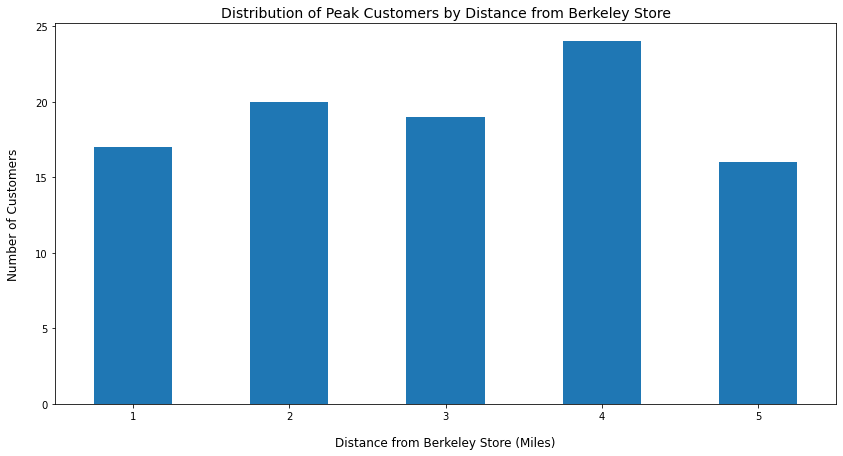

In [74]:
# Plot the results
fig, ax = plt.subplots()
final_df.groupby("distance")["total_customers"].sum().plot(kind="bar", figsize=(14,7))

# Add titles and axes labels
plt.title("Distribution of Peak Customers by Distance from Berkeley Store", fontsize=14)
ax.set_ylabel("Number of Customers", labelpad=15, fontsize=12)
ax.set_xlabel("Distance from Berkeley Store (Miles)", labelpad=15, fontsize=12)
plt.xticks(rotation=0);

# Summary

Since most AGM customers live within 15 miles of the closest store, we recommended considering a delivery service to capture customers who live farther away. We completed a proof of concept with Peak and validated that the relationship could work from a technical perspective. The above analysis, however, should give cause for hesitation in solidifying the relationship.

Ironically, the only customers who signed up for delivery service through Peak were those who live within 5 miles of the Berkeley store. This is not simply due to a relative concentration of addresses near the Berkeley store, as we validated that this distribution is similar to the national one.

Our recommendation is to pause forming a relationship with Peak. We think that additional analysis should be completed prior to entering into contract with them. More specifically, we should (1) determine how similar/different buying patterns are as distance from the closest store increases (perhaps those farther away just buy less frequently) and (2) discuss what Peak will commit to doing with respect to advertising AGM to customers located outside of a given radius of our store.